In [4]:
import ctypes
import struct
import sys

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2



In [6]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
from CPP_MedianFilter.python_packges.PyMedianFilter import PyMedianFilter

In [8]:
def show_img(img, ax=plt):
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)

In [9]:
!ls ./CPP_MedianFilter/resources/inputs/

image0.jpeg  image2.jpeg  image4.jpeg  image6.jpeg  image8.jpeg
image1.jpeg  image3.jpeg  image5.jpeg  image7.jpeg  image9.jpeg


(257, 196, 3)
(225, 225, 3)
(224, 225, 3)
(226, 223, 3)
(225, 225, 3)
(288, 512, 3)
(294, 220, 1)
(359, 478, 3)
(450, 800, 3)
(661, 1000, 3)


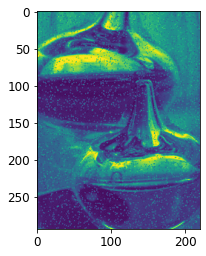

In [10]:
images = [mpimg.imread(f'./CPP_MedianFilter/resources/inputs/image{i}.jpeg') for i in range(10)]
for i, img in enumerate(images):
    if len(img.shape) == 2:
        images[i] = img[..., np.newaxis]
show_img(images[6])
for img in images:
    print(img.shape)

In [11]:
algos = {
    'cv2': lambda img, r : cv2.medianBlur(img, r * 2 + 1),
    'easy': PyMedianFilter().process_easy,
    'medium': PyMedianFilter().process_medium,
    'hard': PyMedianFilter().process_hard,
}

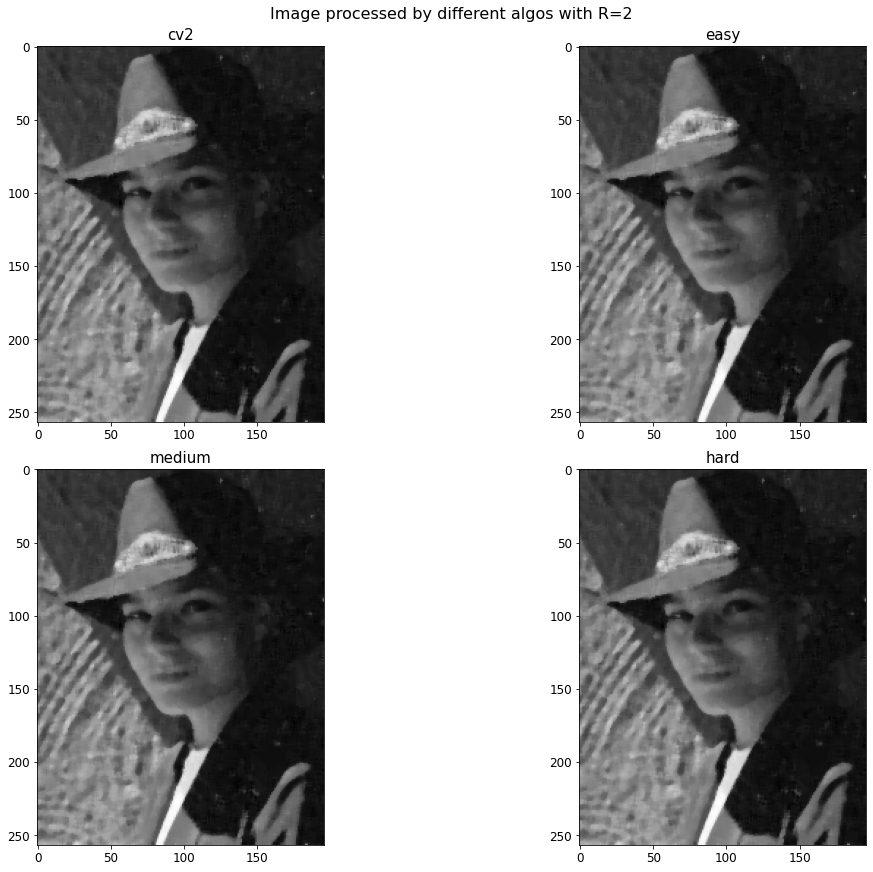

In [12]:
def test_algos(img):
    axes_x = 2
    R = 2
    axes_y = len(algos) // 2 + len(algos) % 2 
    fig, axes = plt.subplots(axes_y, axes_x, constrained_layout=True)
    fig.suptitle(f'Image processed by different algos with R={R}', fontsize=16)
    fig.set_figwidth(15)
    fig.set_figheight(12)
    
    res_cv = np.array(algos['cv2'](img, R))

    for i, (algo_name, algo) in enumerate(algos.items()):
        algo_ax = axes[i // 2, i % 2]
        res = np.array(algo(img, R))
        assert((res == res_cv).all()) #  main_check
        show_img(res, ax=algo_ax)
        algo_ax.set_title(algo_name)
test_algos(images[0][:,:,0])

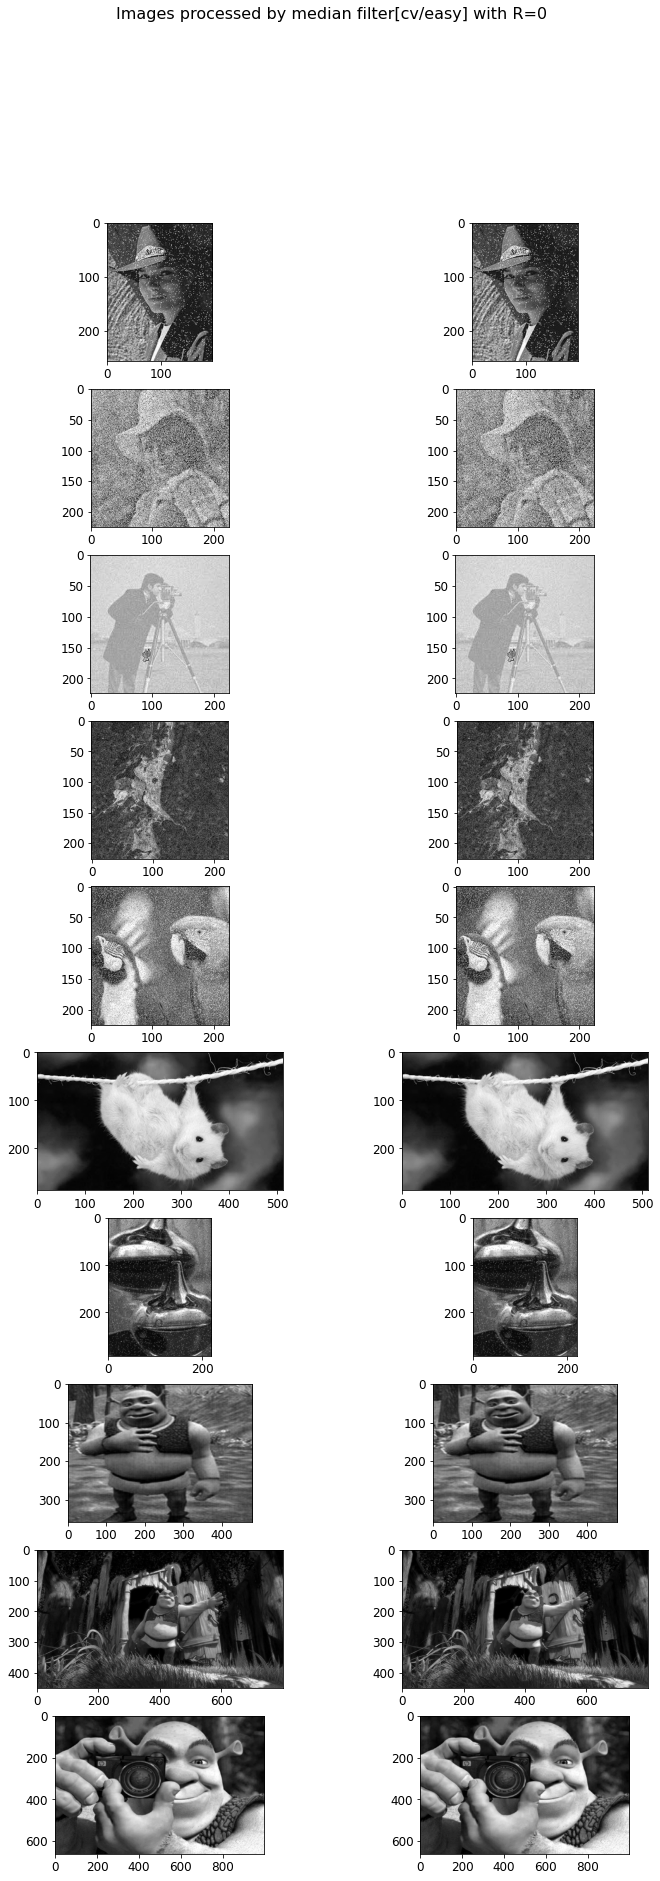

In [13]:
import time

def show_images(imgs, algo_name='easy', R=0):
    axes_x = 2
    axes_y = len(imgs)
    fig, axes = plt.subplots(axes_y, axes_x)
#     fig.tight_layout(pad=3.0)
    fig.suptitle(f'Images processed by median filter[cv/{algo_name}] with R={R}', fontsize=16)
    fig.set_figwidth(12)
    fig.set_figheight(30)
    
    
    time_cv = []
    time_my = []
    for i, img in enumerate(imgs):
        size_mp = img.shape[0] * img.shape[1] / 1000000
        start_time = time.time()
        res_cv = np.array(algos['cv2'](img[:,:,0], R))
        time_cv.append((time.time() - start_time) * 1000 / size_mp)

        start_time = time.time()
        res_my = np.array(algos[algo_name](img[:,:,0], R))
        time_my.append((time.time() - start_time) * 1000 / size_mp)

        show_img(res_cv, ax=axes[i,0])
        show_img(res_my, ax=axes[i,1])
    return time_cv, time_my
time_cv, time_my = show_images(images, algo_name='easy')
# print(time_cv)
# print(time_my)

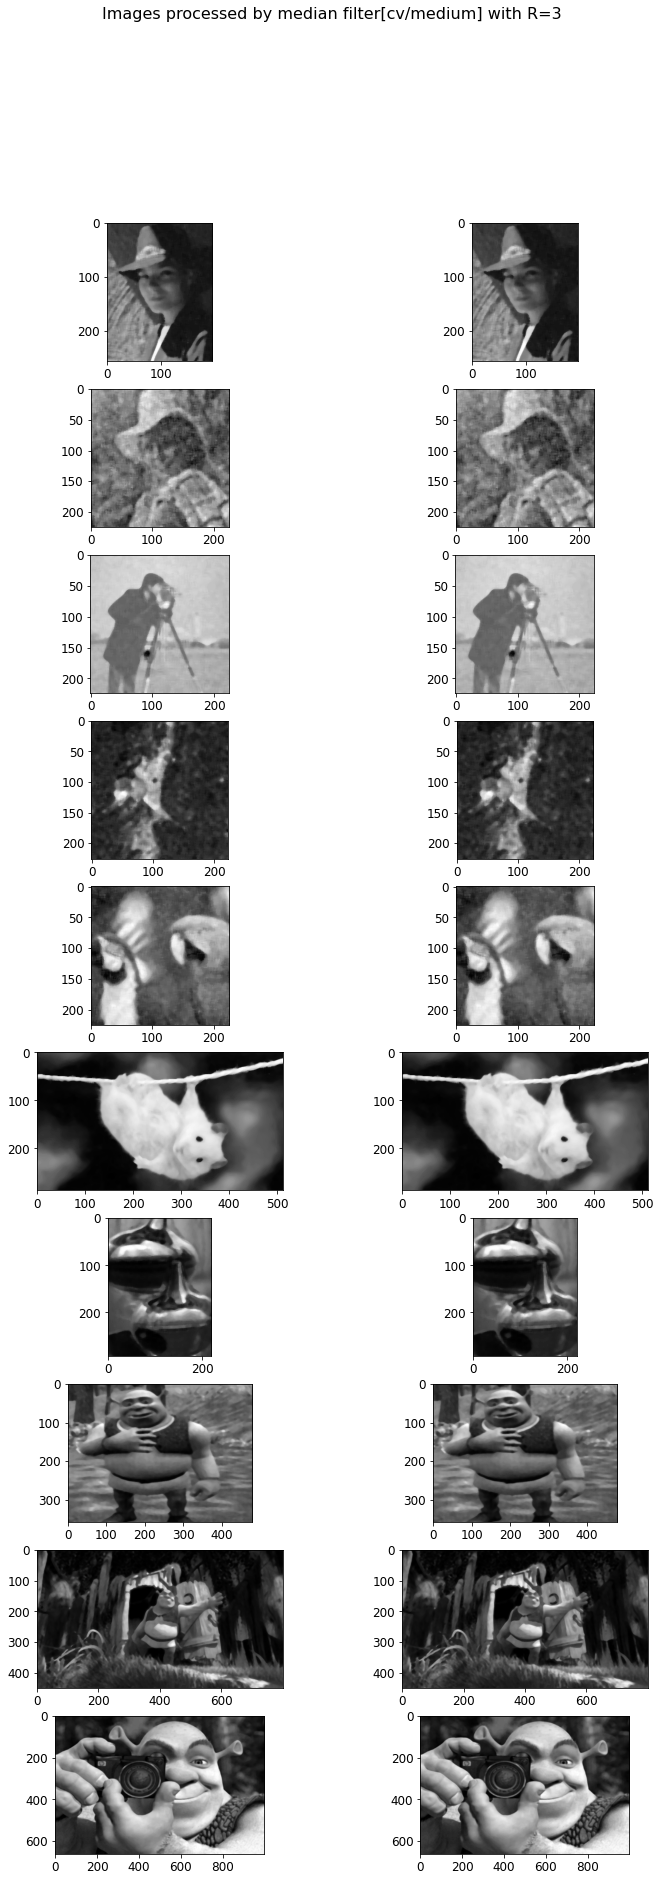

In [14]:
time_cv, time_my = show_images(images, algo_name='medium', R=3)

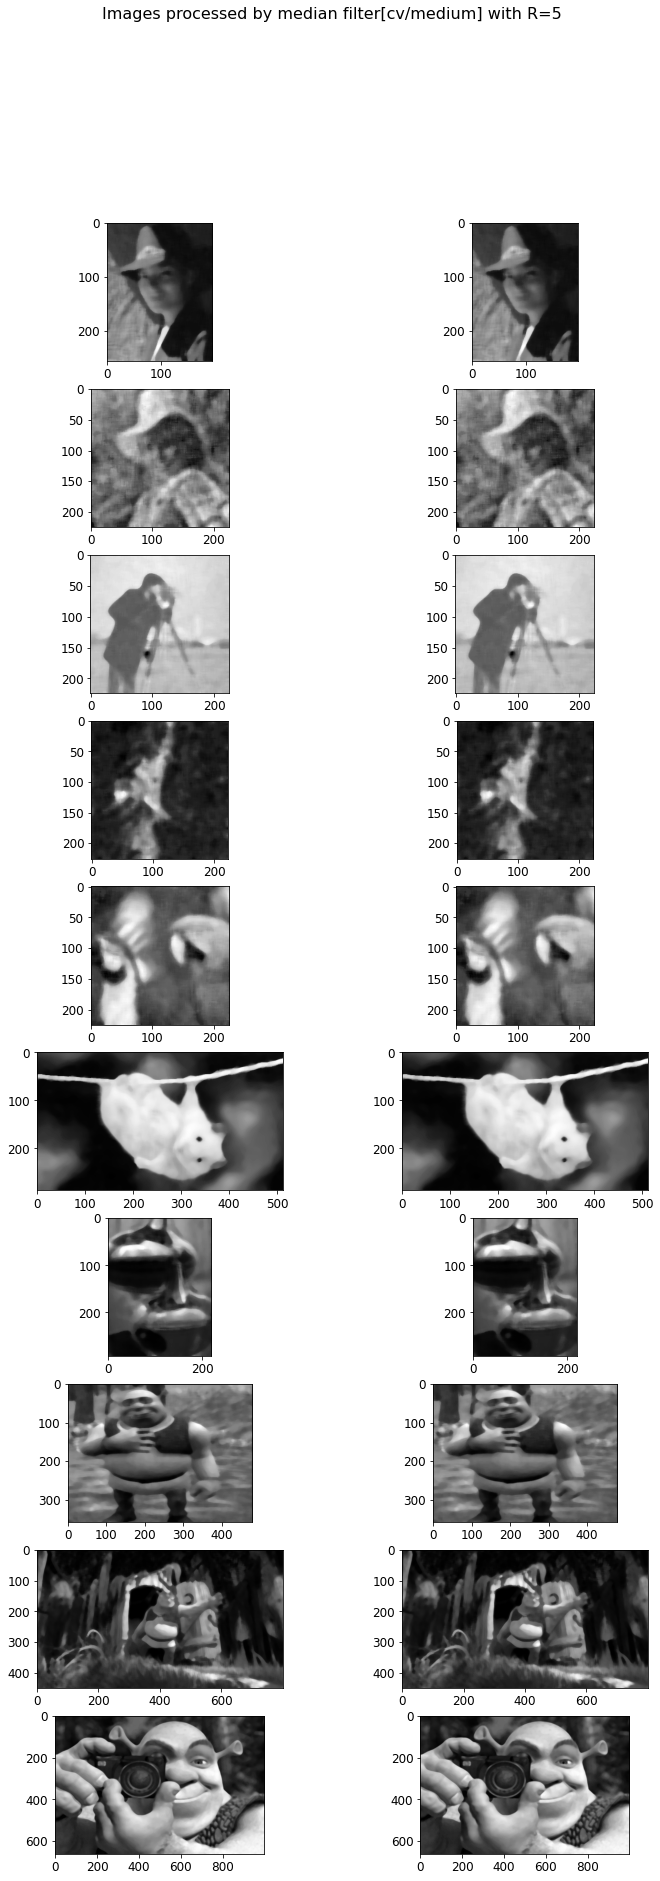

In [15]:
time_cv, time_my = show_images(images, algo_name='medium', R=5)

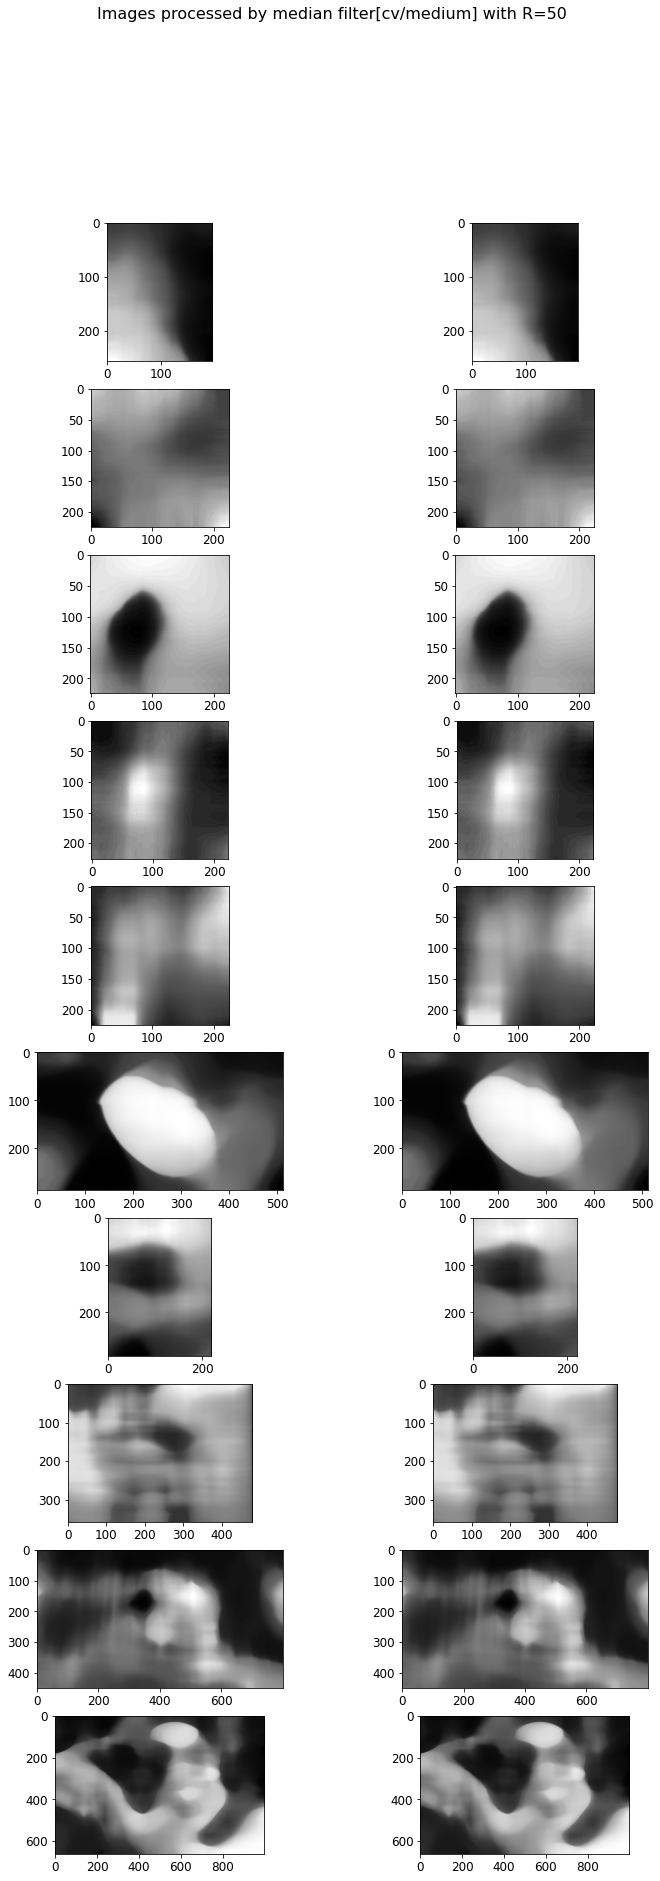

In [16]:
time_cv, time_my = show_images(images, algo_name='medium', R=50)

In [17]:
def process(imgs, algo=algos['easy'], R=2):
    time_my = []
    for i, img in enumerate(imgs):
        size_mp = img.shape[0] * img.shape[1] / 1000000
        start_time = time.time()
        res_my = np.array(algo(img[:,:,0], R))
        time_my.append((time.time() - start_time) * 1000 / size_mp)

    return time_my
process(images, algo=algos['medium'], R=5)

[526.6914997753627,
 551.2143358772183,
 494.66651583474777,
 506.9528904655272,
 526.1927475163966,
 535.7319928912652,
 423.22615303223563,
 405.59862820432824,
 418.03320248921716,
 574.8957260293427]

In [18]:
R_range = list(range(10)) + list(range(10, 50, 5))
print(f'Range {R_range}')
algos_res = {
    'cv2': [],
    'easy': [],
    'medium': [],
    'hard': [],
}
for algo_name in ['cv2', 'easy', 'medium', 'hard']:
    for R in R_range:
        if algo_name == 'easy' and R > 5: # too slow on big R
            continue
        time_algo = process(images, algo=algos[algo_name], R=R)
        result = np.mean(time_algo)
        algos_res[algo_name].append(result)
        print(f'{algo_name} mean: {result}ms/MP for {R}')

Range [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]
cv2 mean: 2.163718742804861ms/MP for 0
cv2 mean: 3.7637650189729386ms/MP for 1
cv2 mean: 13.07520228587058ms/MP for 2
cv2 mean: 49.70750712809836ms/MP for 3
cv2 mean: 43.81938482462344ms/MP for 4
cv2 mean: 55.030658162579336ms/MP for 5
cv2 mean: 56.82707428461039ms/MP for 6
cv2 mean: 65.88546564995265ms/MP for 7
cv2 mean: 39.05084409104756ms/MP for 8
cv2 mean: 32.22519186050205ms/MP for 9
cv2 mean: 40.78508224711993ms/MP for 10
cv2 mean: 42.9952696544119ms/MP for 15
cv2 mean: 30.520910650378323ms/MP for 20
cv2 mean: 38.01282959012286ms/MP for 25
cv2 mean: 36.79064728143475ms/MP for 30
cv2 mean: 33.80174948095091ms/MP for 35
cv2 mean: 33.12400459074062ms/MP for 40
cv2 mean: 30.393093411248763ms/MP for 45
easy mean: 155.61684880051672ms/MP for 0
easy mean: 435.77061111034027ms/MP for 1
easy mean: 723.8711759858674ms/MP for 2
easy mean: 1070.6347450987546ms/MP for 3
easy mean: 1473.9359779357153ms/MP for 4
easy mean: 206

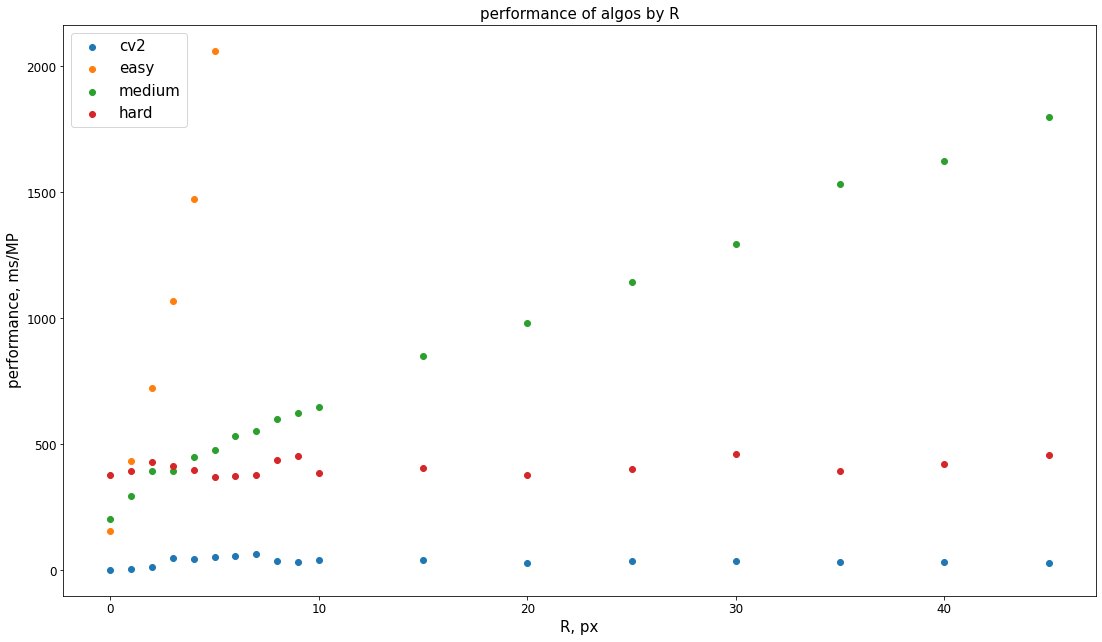

In [19]:
def show_results(algo_names=['cv2', 'easy','medium', 'hard']):
    fig, axes = plt.subplots(1, 1)
    fig.set_size_inches(18.5, 10.5, forward=True)
    for algo_name in algo_names:
        axes.scatter(x=R_range[:len(algos_res[algo_name])], y=algos_res[algo_name], label=algo_name)
        axes.legend()
        axes.set_title('performance of algos by R')
        axes.set_ylabel('performance, ms/MP')
        axes.set_xlabel('R, px')
        
show_results()

In [20]:
print(np.array(algos_res['medium']) < np.array(algos_res['hard']))
th_combined = np.sum(np.array(algos_res['medium']) < np.array(algos_res['hard']))
print(f'Наш порог для комбинированного алгоритма: {th_combined}')

[ True  True  True  True False False False False False False False False
 False False False False False False]
Наш порог для комбинированного алгоритма: 4


In [21]:
def combined_algo(img, r):
    # the easiest case :)
    if r == 0:
        return img
    if r <= th_combined:
        return algos['medium'](img, r)
    else:
        return algos['hard'](img, r)        
algos['combined'] = combined_algo

In [22]:
R_range = list(range(10)) + list(range(10, 50, 5))
print(f'Range {R_range}')
algos_res = {
    'cv2': [],
    'easy': [],
    'medium': [],
    'hard': [],
    'combined': []
}
for algo_name in ['cv2', 'easy', 'medium', 'hard', 'combined']:
    for R in R_range:
        if algo_name == 'easy' and R > 5: # too slow on big R
            continue
        time_algo = process(images, algo=algos[algo_name], R=R)
        result = np.mean(time_algo)
        algos_res[algo_name].append(result)
        print(f'{algo_name} mean: {result}ms/MP for {R}')

Range [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]
cv2 mean: 1.2034930579772642ms/MP for 0
cv2 mean: 3.908442042459849ms/MP for 1
cv2 mean: 9.22779989808779ms/MP for 2
cv2 mean: 40.81605735538273ms/MP for 3
cv2 mean: 49.88416561542473ms/MP for 4
cv2 mean: 48.96961253066037ms/MP for 5
cv2 mean: 55.813418191702795ms/MP for 6
cv2 mean: 66.02649812199878ms/MP for 7
cv2 mean: 48.82455283788835ms/MP for 8
cv2 mean: 31.791486782872347ms/MP for 9
cv2 mean: 33.3391427936226ms/MP for 10
cv2 mean: 40.08593999362891ms/MP for 15
cv2 mean: 35.43039648178033ms/MP for 20
cv2 mean: 32.66641335633405ms/MP for 25
cv2 mean: 27.56925195310522ms/MP for 30
cv2 mean: 32.70589838307292ms/MP for 35
cv2 mean: 42.85413357208173ms/MP for 40
cv2 mean: 30.03390376191698ms/MP for 45
easy mean: 170.56748601211305ms/MP for 0
easy mean: 399.65795945746066ms/MP for 1
easy mean: 790.6908007170613ms/MP for 2
easy mean: 1033.643308360596ms/MP for 3
easy mean: 1548.4650015977645ms/MP for 4
easy mean: 2002.2

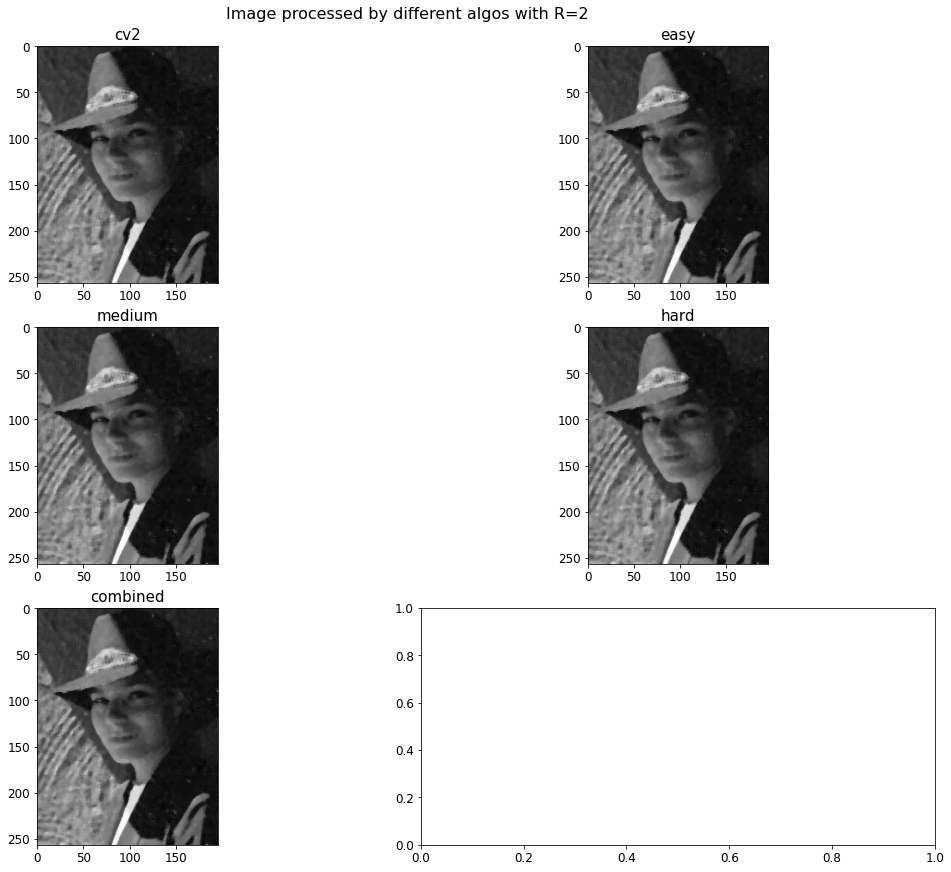

In [23]:
test_algos(images[0][:,:,0])

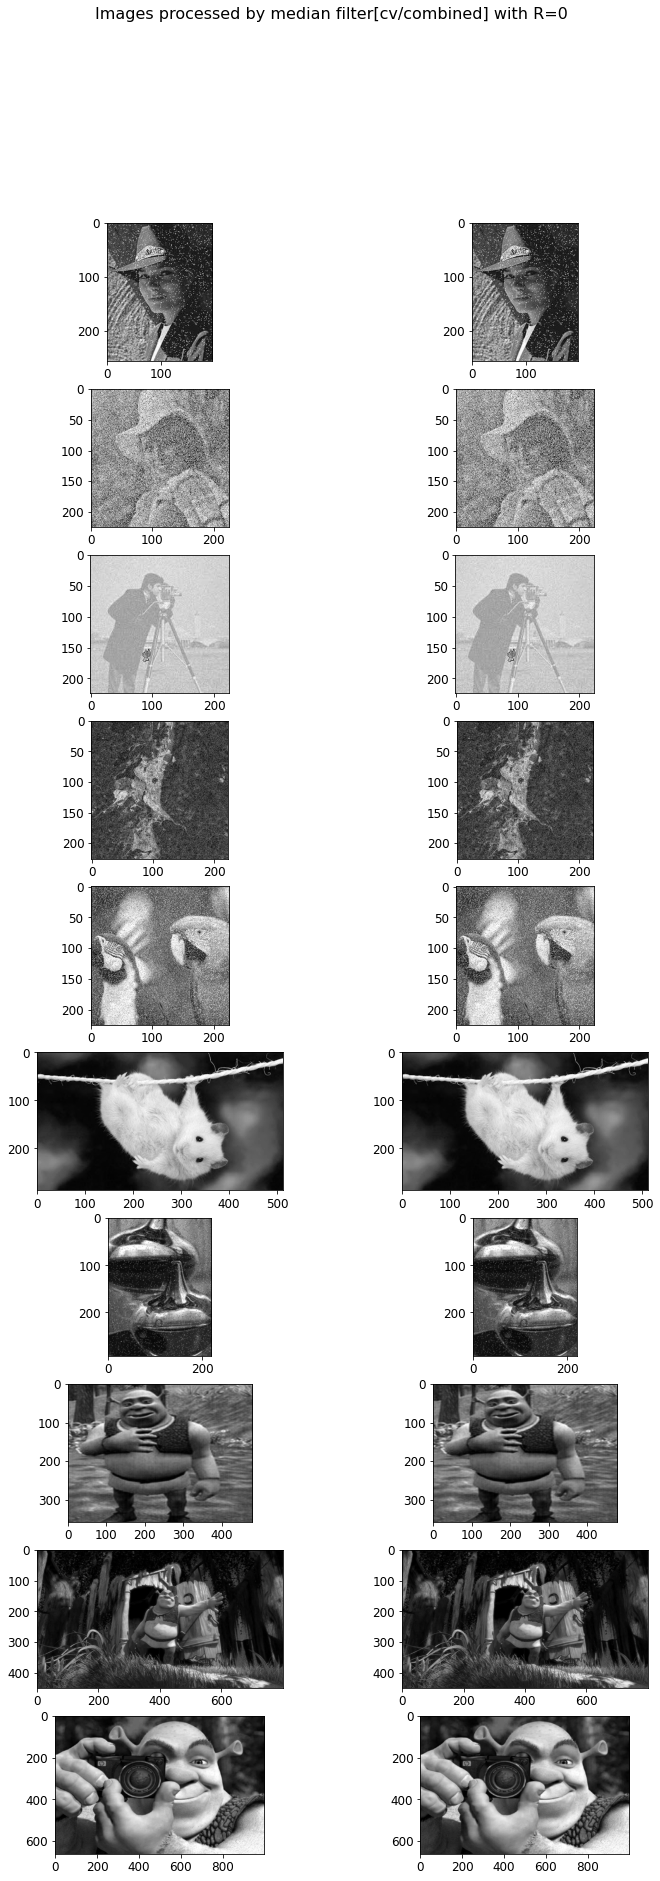

In [25]:
time_cv, time_my = show_images(images, algo_name='combined')

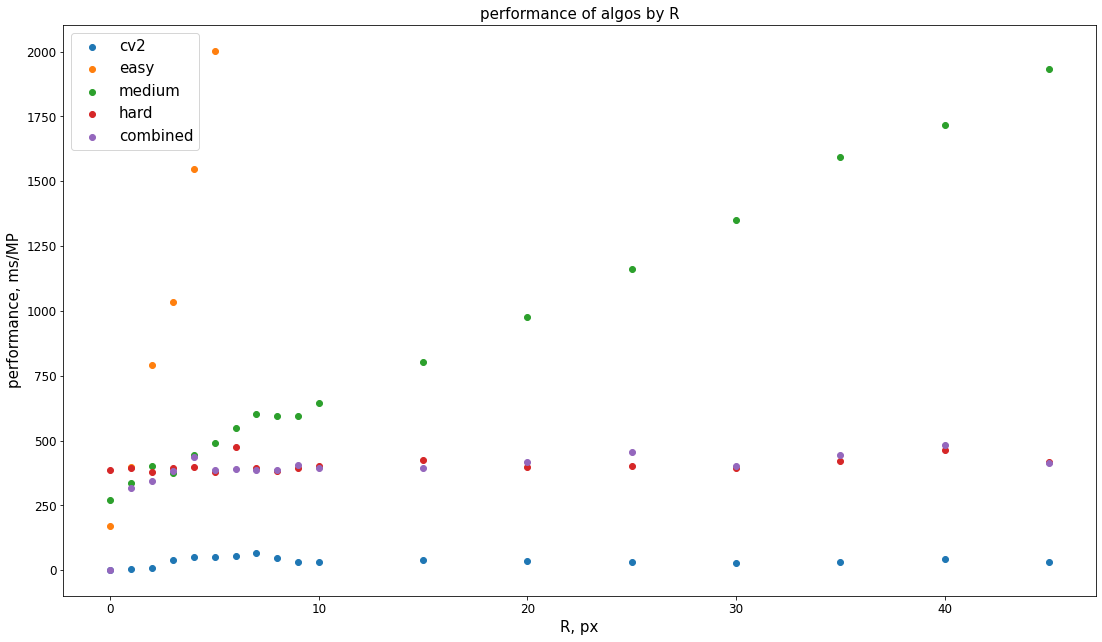

In [26]:
show_results(['cv2', 'easy', 'medium', 'hard', 'combined'])

In [ ]:
def print_img_cpp_vector():
    for i in img[:10,:10,0]:
        s = ','.join(map(str, i))
        print(f'{{{s}}},')